### Scikit IsolationFores

In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder,  StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

data = pd.read_pickle('disch_final.pkl')

In [11]:
iforest = IsolationForest(n_estimators=200, max_samples='auto', 
                          contamination='auto', max_features=.8, 
                          bootstrap=True, n_jobs=-1, random_state=42)
feats = [c for c in data.columns if c not in ['READMISSION-NTW','READMISSION-30', 'READMISSION-7', 'charttime', 
                                          'subject_id', 'hadm_id']]

target30 = data['READMISSION-30']
print(data[feats].shape)

data.fillna(data.mean(), inplace=True)
pred= iforest.fit_predict(data[feats])
data['scores']=iforest.decision_function(data[feats])
data['original_paper_score']= [-1*s + 0.5 for s in data['scores']]
data['anomaly_label']=pred

data[data.anomaly_label==-1].shape

(138761, 54)


<ipython-input-11-3cb575082110>:10: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



(2965, 63)

<AxesSubplot:xlabel='original_paper_score', ylabel='Count'>

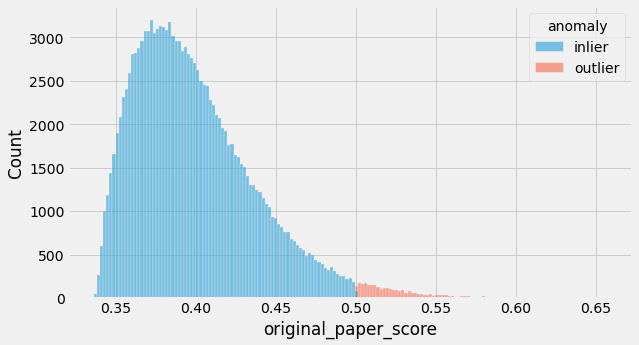

In [12]:
data['anomaly']=data['anomaly_label'].apply(lambda x: 'outlier' if x==-1  else 'inlier')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 5))
sns.histplot(data,x='original_paper_score',hue='anomaly')


<AxesSubplot:xlabel='scores', ylabel='Count'>

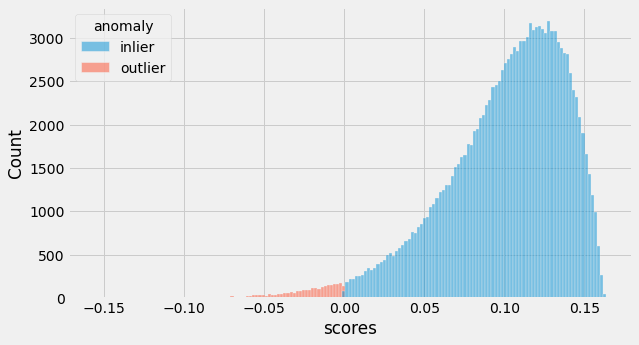

In [13]:
plt.figure(figsize=(9, 5))
sns.histplot(data,x='scores',hue='anomaly')

In [14]:
data.shape

(138761, 64)

In [15]:
data[data['original_paper_score']>0.50].shape

(2965, 64)

In [16]:
data[data['scores']<0].shape

(2965, 64)

### Tune IsolationFores

In [31]:
def tune_IsoForest(data):
    model = IsolationForest(random_state=47)

    param_grid = {'n_estimators': [200, 300], 
                  'max_samples': [20], 
                  'contamination': [.001, .0001, 0.01, .03], 
                  'max_features': [.8], 
                  'bootstrap': [True], 
                  'n_jobs': [-1]}

    grid_search = GridSearchCV(model, param_grid,
                                      scoring="roc_auc", 
                                      refit=True,
                                      cv=3, 
                                      return_train_score=True)
    grid_search.fit(data[feats], target30)

    best_model = grid_search.fit(data[feats], target30)
    print('Optimum parameters', best_model.best_params_)
    return best_model.best_params_
params = tune_IsoForest(data)

Optimum parameters {'bootstrap': True, 'contamination': 'auto', 'max_features': 0.8, 'max_samples': 20, 'n_estimators': 200, 'n_jobs': -1}


In [32]:
params

{'bootstrap': True,
 'contamination': 'auto',
 'max_features': 0.8,
 'max_samples': 20,
 'n_estimators': 200,
 'n_jobs': -1}

In [ ]:


outlier_heal = 1 
if outlier_heal:
    iforest = IsolationForest(n_estimators=200, max_samples='auto', 
                      contamination=0.03, max_features=.8, 
                      bootstrap=False, n_jobs=-1, random_state=42)
    feats = [c for c in data.columns if c not in ['READMISSION-NTW','READMISSION-30', 'READMISSION-7', 'charttime', 
                                      'subject_id', 'hadm_id']]
    print(data[feats].dtypes)

    data.fillna(data.mean(), inplace=True)
    pred= iforest.fit_predict(data[feats])
    data['scores']=iforest.decision_function(data[feats])
    data['original_paper_score']= [-1*s + 0.5 for s in data['scores']]
    data['anomaly_label']=pred

    #print(data[data.anomaly_label==-1].shape)
    data = data[data['original_paper_score']<=0.52]
    drps = ['scores', 'original_paper_score','anomaly_label']
    data.drop(drps, axis=1, inplace=True)
    return data
else: 

    print('just clean data.. Normalization and advanced anomaly healing will presnt on next version ... change config setting ')

---------------------------------------

## Extended IsolationFores(eif) to reduce IF bias
#### https://arxiv.org/pdf/1811.02141.pdf
#### https://dspace.cvut.cz/bitstream/handle/10467/87988/F8-DP-2020-Valenta-Adam-thesis.pdf

-----------------------------------------------

### Limitations of Isolation Forest:
    Isolation Forests are computationally efficient and
    have been proven to be very effective in Anomaly detection. Despite its advantages, there are a few limitations as mentioned below.

    1.The final anomaly score depends on the contamination parameter, provided while training the model. This implies that we should have an idea of what percentage of the data is anomalous beforehand to get a better prediction.

    2. Also, the model suffers from a bias due to the way the branching takes place.

In [31]:
!pip install requests

In [32]:
!pip install tabulate


In [33]:
!pip install future

In [ ]:
!pip uninstall h2o

In [1]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 176.2 MB 62 kB/s /s eta 0:00:01   |██████████████▎                 | 78.7 MB 16.5 MB/s eta 0:00:06
  Created wheel for h2o: filename=h2o-3.36.0.3-py2.py3-none-any.whl size=176244302 sha256=c2286e8dfb3686a21ccd0c145c594bb91466ed4262649d25973d4c87a654d1f0
  Stored in directory: /home/arash/.cache/pip/wheels/33/d8/e3/bfb993adafc3caa68623779bb744f889d999ff68b2a776b75f
Successfully built h2o


In [4]:
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,9 mins 45 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_arash_ri02fb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.93 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


In [5]:
data = pd.read_pickle('disch_final.pkl')
feats = [c for c in data.columns if c not in ['READMISSION-NTW','READMISSION-30', 'READMISSION-7', 'charttime', 
                                          'subject_id', 'hadm_id']]

target30 = data['READMISSION-30']
print(data[feats].shape)

(138761, 54)


In [6]:
h2o_df = h2o.H2OFrame(data)

# Set the predictors
feats = [c for c in data.columns if c not in ['READMISSION-NTW','READMISSION-30', 'READMISSION-7', 'charttime', 
                                          'subject_id', 'hadm_id']]

# Define an Extended Isolation forest model
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 200,
                                          sample_size = 256,
                                          extension_level = len(feats) - 1)

# Train Extended Isolation Forest
eif.train(x = feats,
          training_frame = h2o_df)

# Calculate score
eif_result = eif.predict(h2o_df)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [7]:
eif_df = eif_result.as_data_frame()
eif_df

,anomaly_score,mean_length
0,0.418240,12.883788
1,0.320926,16.798206
2,0.320926,16.798206
3,0.320926,16.798206
4,0.320926,16.798206
...,...,...
138756,0.534076,9.270309
138757,0.467257,11.245804
138758,0.320926,16.798206
138759,0.543302,9.017167


In [8]:
data = pd.concat([data, eif_df], axis=1)
data

,subject_id,hadm_id,dischtime_day,dischtime_hour,admittime_day,admittime_hour,admission_type,admission_location,discharge_location,insurance,...,Potassium,RDW,RDW-SD,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH,anomaly_score,mean_length
0,10000084,23052089,21,1,21,1,4,10,7,1,...,4.0,12.8,44.4,4.02,140.0,10.0,7.0,NaN,0.418240,12.883788
1,10000560,28979390,15,10,15,10,6,6,6,2,...,3.8,12.8,NaN,3.82,138.0,10.0,7.6,NaN,0.320926,16.798206
2,10000719,24558333,15,0,15,0,7,6,6,2,...,NaN,15.2,NaN,2.80,NaN,NaN,4.9,NaN,0.320926,16.798206
3,10000724,20823482,24,17,24,17,4,2,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320926,16.798206
4,10000764,27897940,14,23,14,23,7,8,7,1,...,4.3,12.9,NaN,3.85,142.0,30.0,4.2,NaN,0.320926,16.798206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138756,19999625,27638769,6,17,6,17,4,2,7,1,...,3.9,13.6,NaN,3.01,140.0,17.0,3.2,NaN,0.534076,9.270309
138757,19999784,26194817,18,21,18,21,5,6,6,2,...,4.7,13.8,42.4,4.54,141.0,16.0,3.2,NaN,0.467257,11.245804
138758,19999828,29734428,18,16,18,16,4,6,7,2,...,NaN,17.8,51.2,4.38,NaN,NaN,9.3,NaN,0.320926,16.798206
138759,19999840,26071774,25,0,25,0,4,2,6,2,...,3.7,14.2,NaN,4.69,140.0,10.0,12.8,NaN,0.543302,9.017167


In [12]:
data[data.anomaly_score>.7].shape

(60, 62)

In [14]:
data.anomaly_score.mean()

0.3990582823171361

/anaconda/envs/py38_default/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='anomaly_score', ylabel='Density'>

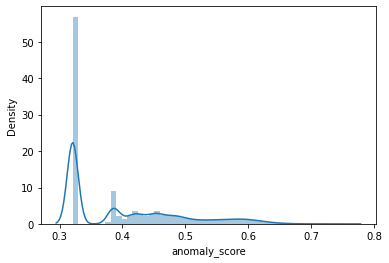

In [15]:
sns.distplot(data.anomaly_score)